## TCo319 remapped

In [73]:
from dask.distributed import Client
client = Client(scheduler_file='/proj/eunbyeol/MPI/scheduler.json')  
client

<Client: 'tcp://203.247.189.225:37629' processes=6 threads=108, memory=502.91 GiB>

In [74]:
import xarray as xr
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob

from dask.diagnostics import ProgressBar
import warnings
warnings.filterwarnings("ignore")

In [75]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmcrameri.cm as cm 
import cmocean


In [76]:
# -------------------
# 1) YEAR RANGE FUNCTION (FIXED)
# -------------------
def extract_year_range(fname):
    m = re.search(r'_(\d{6})-(\d{6})\.nc$', fname)
    if m:
        y1 = int(m.group(1)[0:4])
        y2 = int(m.group(2)[0:4])
        return y1, y2
    return None, None 
   

In [77]:
def select_files(files, base, target, start_year, end_year):
    paths = []

    for f in files:
        year = int(f.split('_')[-1].split('-')[0])

        if start_year <= year <= end_year:
            paths.append(os.path.join(base, f))

    return paths


In [78]:
def open_dataset(files):
    ds = xr.open_mfdataset(files, combine='by_coords', parallel=True, chunks={"time": 100})
    print(ds.dims)
    print(ds.data_vars)
    return ds

In [79]:
def select_variable(ds, var_key, start_year, end_year):
    """Select variable from dataset and slice by time."""
    if var_key not in ds:
        raise KeyError(f"Variable {var_key} not found. Available: {list(ds.data_vars.keys())}")
    
    da = ds[var_key]
    time_dim = "time_counter" if "time_counter" in da.dims else "time"
    da_sel = da.sel({time_dim: slice(f"{start_year}-01-01", f"{end_year}-12-31")})
    
    return da_sel

In [80]:
def compute_mean(da):
    time_dim = "time_counter" if "time_counter" in da.dims else "time"
    return da.mean(dim=time_dim).compute()

def compute_std(da):
    time_dim = "time_counter" if "time_counter" in da.dims else "time"
    return da.std(dim=time_dim).compute()

def compute_std_anomaly(da):
    time_dim = "time_counter" if "time_counter" in da.dims else "time"
    
    # remove leaf day
    da_noleap = da.sel({time_dim: ~((da[time_dim].dt.month==2) & (da[time_dim].dt.day==29))})
    
    # daily climatology
    clim = da_noleap.groupby(f"{time_dim}.dayofyear").mean(dim=time_dim)
    
    # anomaly
    anom = da_noleap.groupby(f"{time_dim}.dayofyear") - clim
    
    # std
    from dask.diagnostics import ProgressBar
    with ProgressBar():
        return anom.std(dim=time_dim).compute()


In [81]:
def open_and_select(files, base, target, start_year, end_year):
    var_key = target
    # var_key = target.split("_", 1)[1]
    sel_files = select_files(files, base, target, start_year, end_year)

    # 파일 갯수만 출력
    print(f"Selected files for {target} ({start_year}-{end_year}): {len(sel_files)} files")

    ds = open_dataset(sel_files)
    da = select_variable(ds, var_key, start_year, end_year)
    return da

In [82]:
model = 'awicm3'
expid = 'TCo319-DART' 
version = 'ctl1950d'
realm = 'oifs'
base_p = f"/proj/shared_data/{model}/{expid}-{version}-gibbs-charn/outdata/{realm}/1d/10ws"
  

In [83]:
model = 'awicm3'
expid = 'TCo319-DART' 
version = 'ssp585d'
realm = 'oifs'
base_f = f"/proj/shared_data/{model}/{expid}-{version}-gibbs-charn/outdata/{realm}/1d/10ws"


In [84]:
# -------------------
# Target period
# -------------------
p_start_year = 1950
p_end_year = 1969
f_start_year = 2080
f_end_year = 2092

In [86]:
# -------------------
# Figure folder
# -------------------
folder_name = "../figure_Hackathon2025_AG/TCo319"     # figure folder         
save_dir = os.path.join(os.getcwd(), folder_name)  
os.makedirs(save_dir, exist_ok=True)

In [87]:
files = glob.glob(os.path.join(base_f, "*.nc"))

unique_vars = set()

pattern = re.compile(r"atm_remapped_(.+?)_(?:\d+[hdm](?:_pl)?)_\d{4}-\d{4}\.nc$")

for f in files:
    fname = os.path.basename(f)
    m = pattern.match(fname)
    if m:
        unique_vars.add(m.group(1))
result_list = sorted(unique_vars)
print(result_list)

['1d_10ws']


In [88]:
# -------------------
# Get file list
# -------------------
files_f = os.listdir(base_f)
files_f = sorted(files_f, key=lambda x: int(x.split('_')[-1].split('-')[0]))

files_p = os.listdir(base_p)
files_p = sorted(files_p, key=lambda x: int(x.split('_')[-1].split('-')[0]))


In [89]:
# -------------------
# Target variable
# -------------------
target = "10ws"
var_key = target
var_key

'10ws'

In [90]:
# ---- Load data ----
da_p = open_and_select(files_p, base_p, target, p_start_year, p_end_year)
da_f = open_and_select(files_f, base_f, target, f_start_year, f_end_year)


Selected files for 10ws (1950-1969): 20 files
FrozenMappingWarningOnValuesAccess({'time_counter': 7305, 'bnds': 2, 'lat': 640, 'lon': 1312})
Data variables:
    time_counter_bnds  (time_counter, bnds) datetime64[ns] 117kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    10ws               (time_counter, lat, lon) float32 25GB dask.array<chunksize=(1, 640, 1312), meta=np.ndarray>
Selected files for 10ws (2080-2092): 13 files
FrozenMappingWarningOnValuesAccess({'time_counter': 4749, 'bnds': 2, 'lat': 640, 'lon': 1312})
Data variables:
    time_counter_bnds  (time_counter, bnds) datetime64[ns] 76kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    10ws               (time_counter, lat, lon) float32 16GB dask.array<chunksize=(1, 640, 1312), meta=np.ndarray>


## Mean, Std

In [70]:
# ---- Compute mean -----------
da_mean_p = compute_mean(da_p)
da_mean_f = compute_mean(da_f)

# ---- Compute std with anomaly ---------
da_std_ano_p = compute_std_anomaly(da_p)
da_std_ano_f = compute_std_anomaly(da_f)

# ---- Compute std -----------
# da_std_p = compute_std(da_p)
# da_std_f = compute_std(da_f)

In [71]:
long_name = 'Wind speed'

lat = da_mean_p['lat'].values   
lon = da_mean_p['lon'].values 

# mean
hist = da_mean_p.values          
fut = da_mean_f.values
diff = fut - hist


Figure saved to: /mnt/lustre/proj/eunbyeol/Hackathon2025_AG/../figure_Hackathon2025_AG/TCo319/10ws_mean_TCo319-DART.png


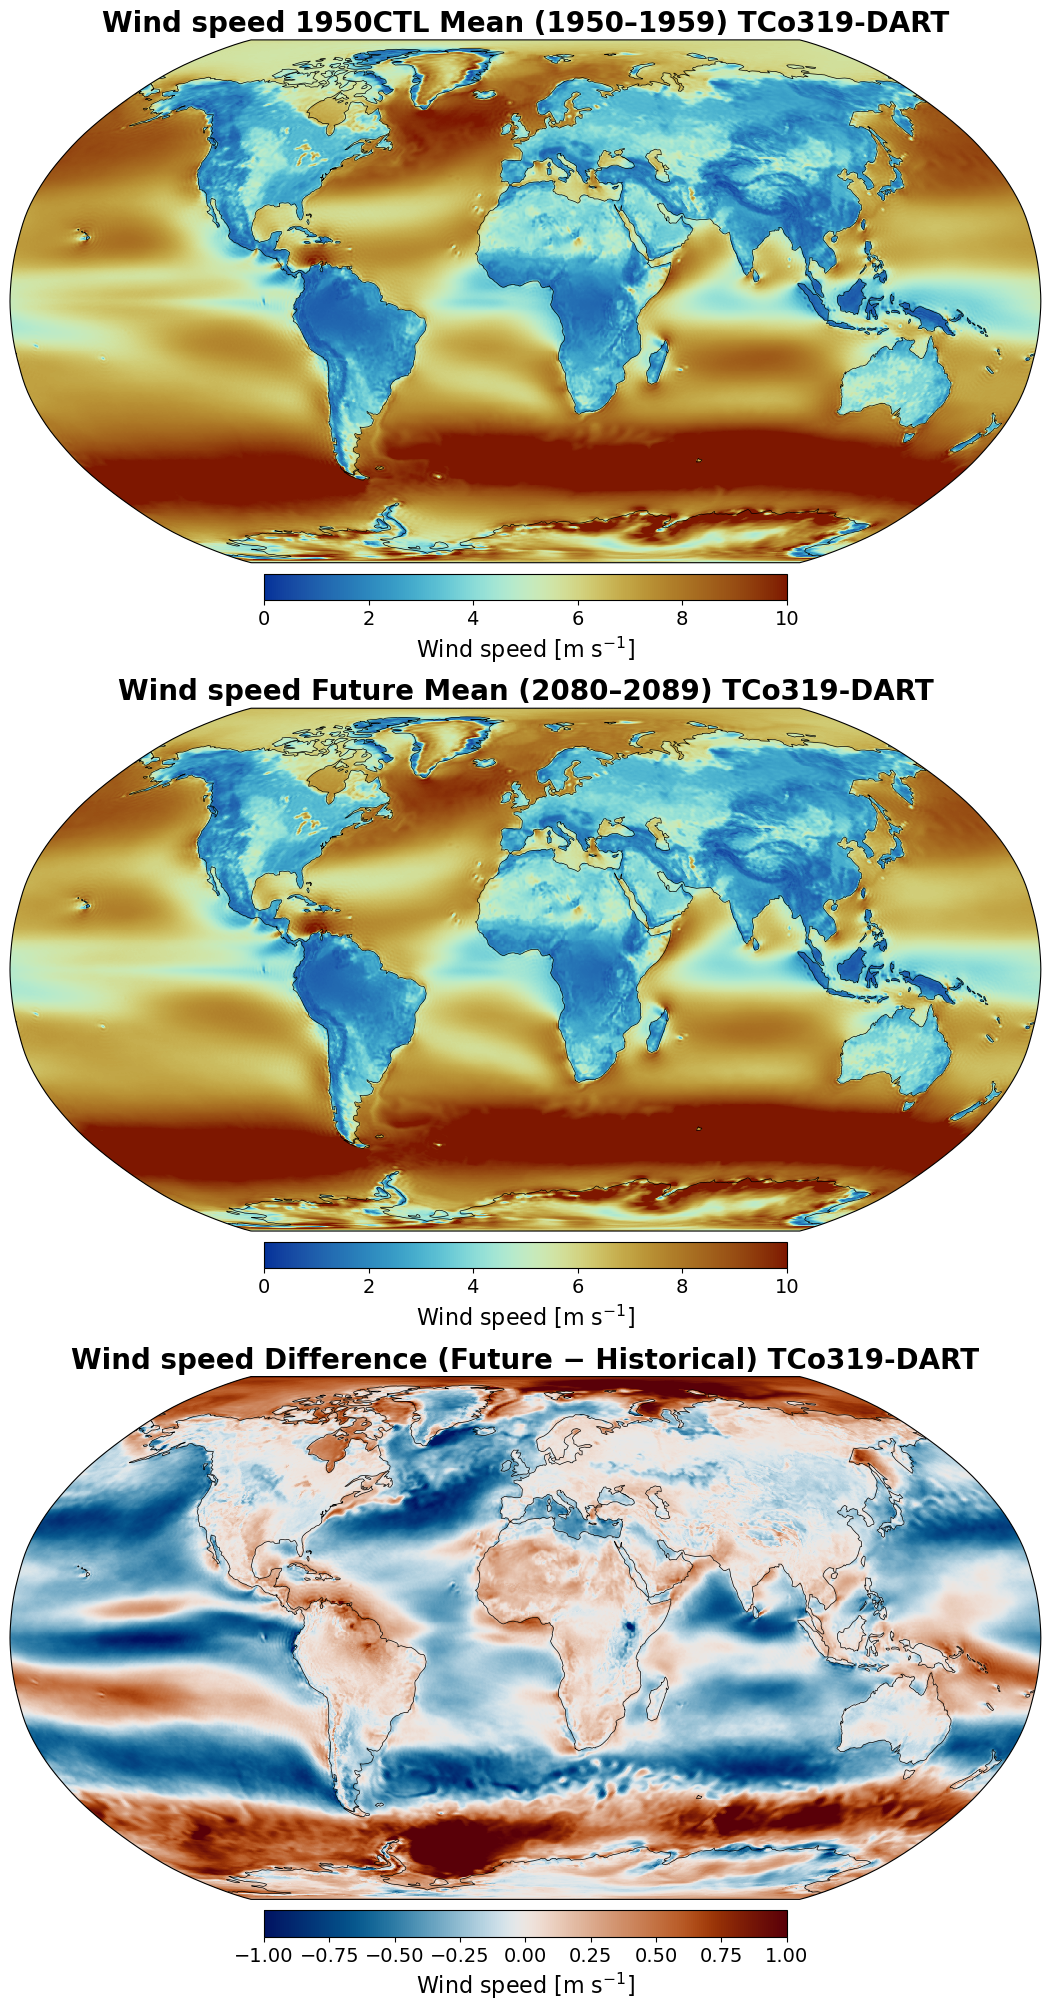

In [158]:
c_ranges = [(0, 10), (0, 10), (-1, 1)]

datasets = [hist, fut, diff]
titles = [
    f'{long_name} 1950CTL Mean (1950–1959) {expid}',
    f'{long_name} Future Mean (2080–2089) {expid}',
    f'{long_name} Difference (Future − Historical) {expid}'
]
fig, axes = plt.subplots(
    3, 1,
    figsize=(12, 20),
    subplot_kw={'projection': ccrs.Robinson()},
    constrained_layout=True
)

# meshgrid
lon2d, lat2d = np.meshgrid(lon, lat)

for ax, data, title, (vmin, vmax) in zip(axes, datasets, titles, c_ranges):
    ax.set_global()
    ax.coastlines(linewidth=0.5)    
   
    im = ax.pcolormesh(
        lon2d, lat2d, data,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),
        shading='auto',       
        cmap = cm.vik if "Difference" in title else cm.roma_r 
    )

    ax.set_title(title, fontsize=20, fontweight='bold')
    
    cbar = fig.colorbar(im, ax=ax, orientation='horizontal', pad=0.02, shrink=0.75,fraction=0.05)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(
        f"{long_name} [m s$^{{-1}}$]" if title != "Difference (Future − Historical)" else "Convective precipitation",
        size='16'
    )

save_path = os.path.join(save_dir, f"{var_key}_mean_{expid}.png")

fig.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

## Land-Sea breeze

In [114]:
# -------------------
# coastal line
# -------------------
path = "/proj/sunseon/PROJ/AWI-CM3/Sea-Land-breeze/data/tco319.coastal.region.theta.nc"
# path = "/proj/sunseon/PROJ/AWI-CM3/Sea-Land-breeze/data/tco319.coastal.region.theta.0-360.nc"
# path = "/proj/sunseon/PROJ/AWI-CM3/Sea-Land-breeze/data/tco319.coastal.region.theta.by.lonFlip.nc"

ds = xr.open_dataset(path)
print(ds)
theta = ds['theta']
mask = xr.where(~np.isnan(theta), 1, 0)
mask_ds = mask.to_dataset(name='mask')
out_path = os.path.join(save_dir, "tco319.coastal.region.mask.nc")

# Save as NetCDF 
mask_ds.to_netcdf(out_path)
print("Mask file saved to:", out_path)


<xarray.Dataset> Size: 10MB
Dimensions:  (lat: 640, lon: 1312)
Coordinates:
  * lat      (lat) float64 5kB -89.86 -89.58 -89.3 -89.02 ... 89.3 89.58 89.86
  * lon      (lon) float64 10kB 0.0 0.2744 0.5488 0.8232 ... 359.2 359.5 359.7
Data variables:
    coastal  (lat, lon) float64 7MB ...
    theta    (lat, lon) float32 3MB ...
Mask file saved to: /mnt/lustre/proj/eunbyeol/Hackathon2025_AG/../figure_Hackathon2025_AG/TCo319/tco319.coastal.region.mask.nc


Figure saved to: /mnt/lustre/proj/eunbyeol/Hackathon2025_AG/../figure_Hackathon2025_AG/TCo319/theta_field_TCo319-DART.png


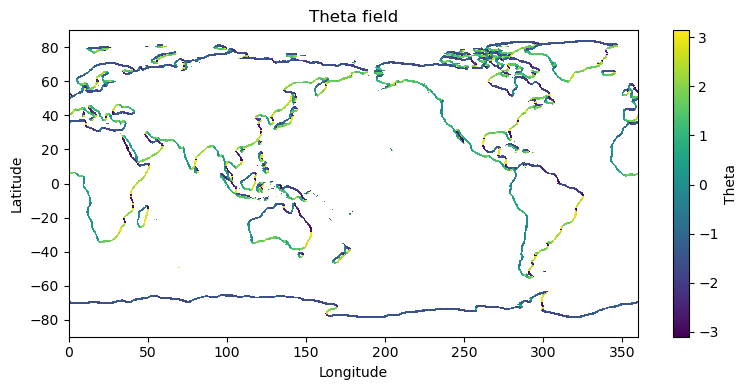

In [115]:
plt.figure(figsize=(8, 4))
im = plt.pcolormesh(ds['lon'], ds['lat'], theta, shading='auto')
plt.colorbar(im, label="Theta")
plt.title("Theta field")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()

save_path = os.path.join(save_dir, f"theta_field_{expid}.png")
fig.savefig(save_path, dpi=100, bbox_inches='tight')
print(f"Figure saved to: {save_path}")


plt.show()

## Masked wind speed

In [121]:
# ----------------------------
# Mask 
# ----------------------------
hist_masked = hist * mask
fut_masked  = fut  * mask
diff_masked = diff * mask

import numpy as np

hist_masked_np = np.where(mask.values == 1, hist, np.nan)
fut_masked_np  = np.where(mask.values == 1, fut,  np.nan)
diff_masked_np = np.where(mask.values == 1, diff, np.nan)



In [125]:
np.isnan(hist_masked_np).sum()

786615

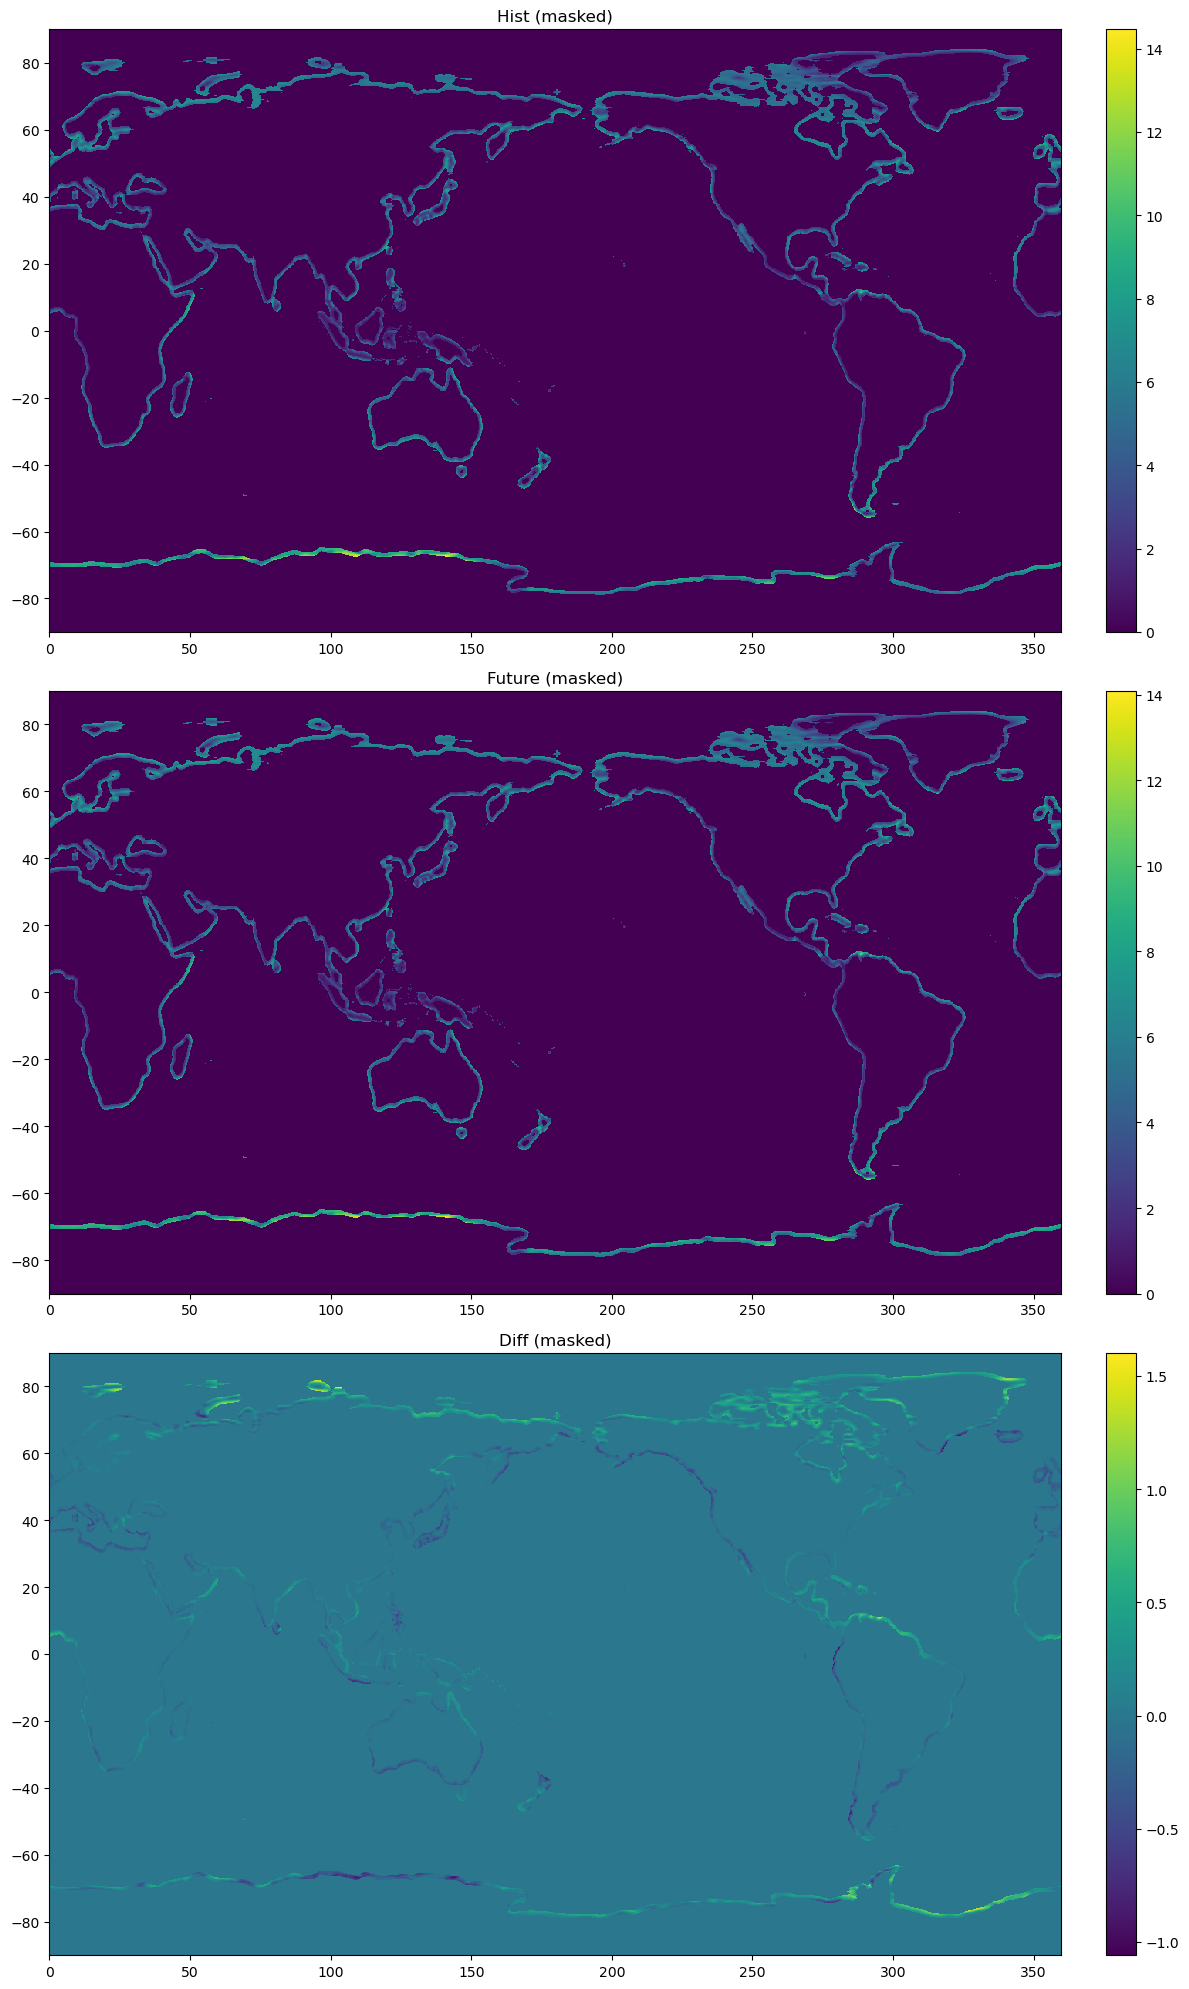

In [124]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(3, 1, figsize=(12, 20))

# 1) hist_masked
im1 = axes[0].pcolormesh(hist_masked.lon, hist_masked.lat, hist_masked,
                         shading='auto')
axes[0].set_title("Hist (masked)")
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# 2) fut_masked
im2 = axes[1].pcolormesh(fut_masked.lon, fut_masked.lat, fut_masked,
                         shading='auto')
axes[1].set_title("Future (masked)")
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# 3) diff_masked
im3 = axes[2].pcolormesh(diff_masked.lon, diff_masked.lat, diff_masked,
                         shading='auto')
axes[2].set_title("Diff (masked)")
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


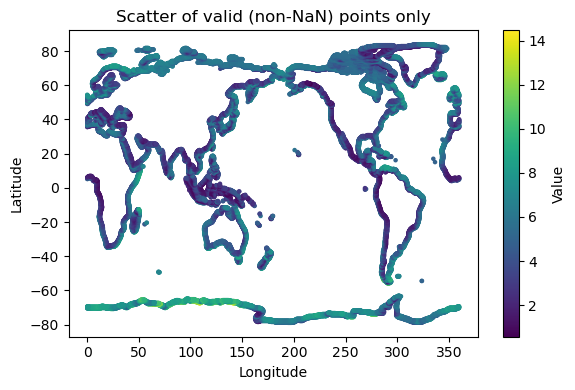

In [127]:
import numpy as np
import matplotlib.pyplot as plt

# make 2D meshgrid 
lon2, lat2 = np.meshgrid(lon, lat)

# select isnan point
mask_valid = ~np.isnan(hist_masked_np)

# 3) scatter plot
plt.figure(figsize=(6,4))
plt.scatter(lon2[mask_valid], lat2[mask_valid],
            c=hist_masked_np[mask_valid],
            s=5, cmap='viridis')

plt.colorbar(label="Value")
plt.title("Scatter of valid (non-NaN) points only")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


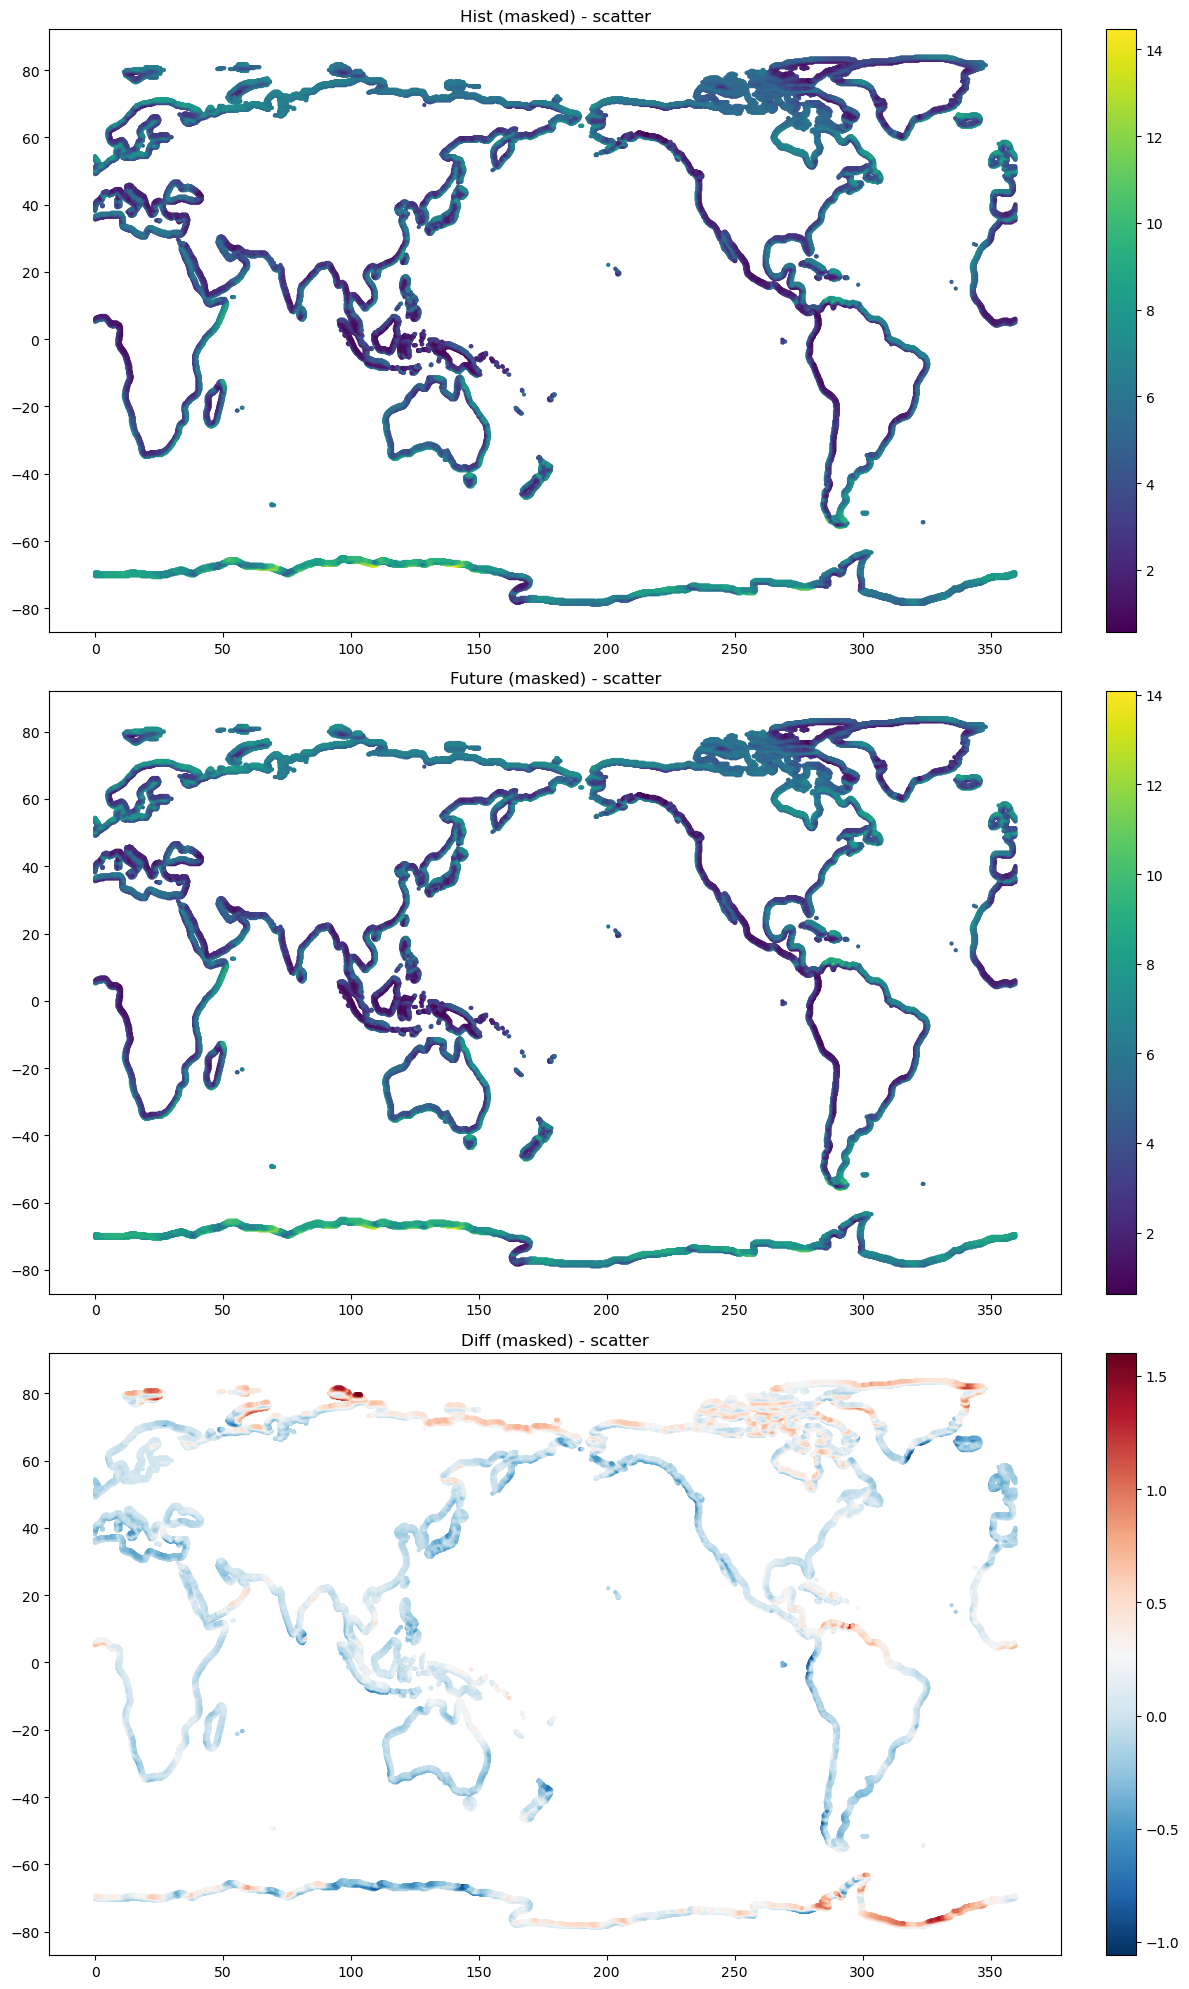

In [129]:
import numpy as np
import matplotlib.pyplot as plt


lon2, lat2 = np.meshgrid(hist_masked.lon, hist_masked.lat)

mask_hist = ~np.isnan(hist_masked_np)
mask_fut  = ~np.isnan(fut_masked_np)
mask_diff = ~np.isnan(diff_masked_np)

fig, axes = plt.subplots(3, 1, figsize=(12, 20))

# 1) Hist (masked)
sc1 = axes[0].scatter(lon2[mask_hist], lat2[mask_hist],
                      c=hist_masked.values[mask_hist],
                      s=4, cmap='viridis')
axes[0].set_title("Hist (masked) - scatter")
plt.colorbar(sc1, ax=axes[0], fraction=0.046, pad=0.04)

# 2) Future (masked)
sc2 = axes[1].scatter(lon2[mask_fut], lat2[mask_fut],
                      c=fut_masked.values[mask_fut],
                      s=4, cmap='viridis')
axes[1].set_title("Future (masked) - scatter")
plt.colorbar(sc2, ax=axes[1], fraction=0.046, pad=0.04)

# 3) Diff (masked)
sc3 = axes[2].scatter(lon2[mask_diff], lat2[mask_diff],
                      c=diff_masked.values[mask_diff],
                      s=4, cmap='RdBu_r')
axes[2].set_title("Diff (masked) - scatter")
plt.colorbar(sc3, ax=axes[2], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


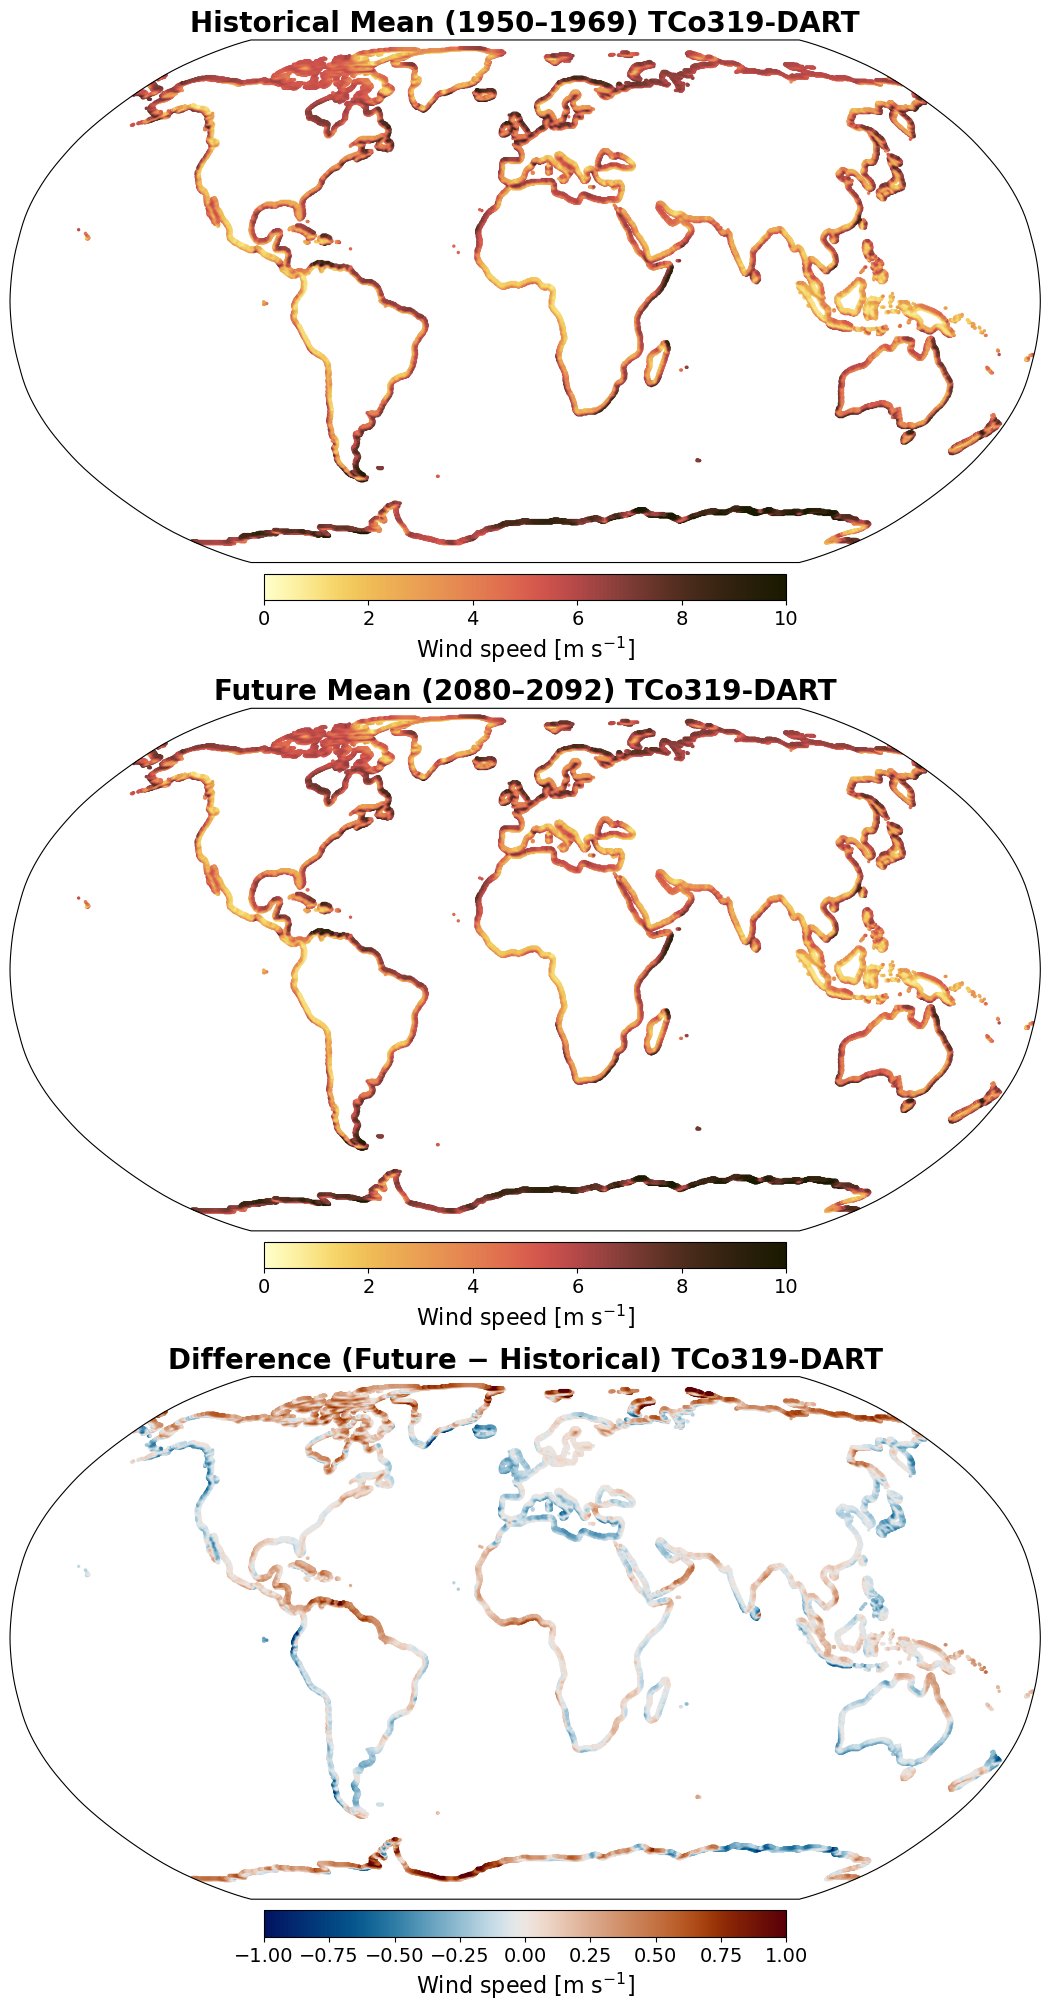

In [143]:
import numpy as np
import matplotlib.pyplot as plt

lon2, lat2 = np.meshgrid(hist_masked.lon, hist_masked.lat)

c_ranges = [(0, 10), (0, 10), (-1, 1)]
datasets = [hist_masked_np, fut_masked_np, diff_masked_np]
colormaps = [cm.lajolla_r, cm.lajolla_r, cm.vik]

titles = [
    f'Historical Mean ({p_start_year}–{p_end_year}) {expid}',
    f'Future Mean ({f_start_year}–{f_end_year}) {expid}',
    f'Difference (Future − Historical) {expid}'
]

fig, axes = plt.subplots(
    3, 1,
    figsize=(12, 20),
    subplot_kw={'projection': ccrs.Robinson()},
    constrained_layout=True
)

for ax, data, title, (vmin, vmax), cmap_used in zip(axes, datasets, titles, c_ranges, colormaps):
    ax.set_global()
    # ax.coastlines(linewidth=0.1)
    sc = ax.scatter(
        lon2,
        lat2,
        c=data,
        s=2,
        vmin=vmin, vmax=vmax,
        transform=ccrs.PlateCarree(),  
        cmap=cmap_used
    )
    ax.set_title(title, fontsize=20, fontweight='bold')

    cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', pad=0.02, shrink=0.75,fraction=0.05)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(
        f"{long_name} [m s$^{{-1}}$]" if title != "Difference (Future − Historical)" else "Convective precipitation",
        size='16'
    )

# save_path = os.path.join(save_dir, f"{var_key}_mean_{expid}_masked.png")
# fig.savefig(save_path, dpi=300, bbox_inches='tight')
# print(f"Figure saved to: {save_path}")  

plt.show()


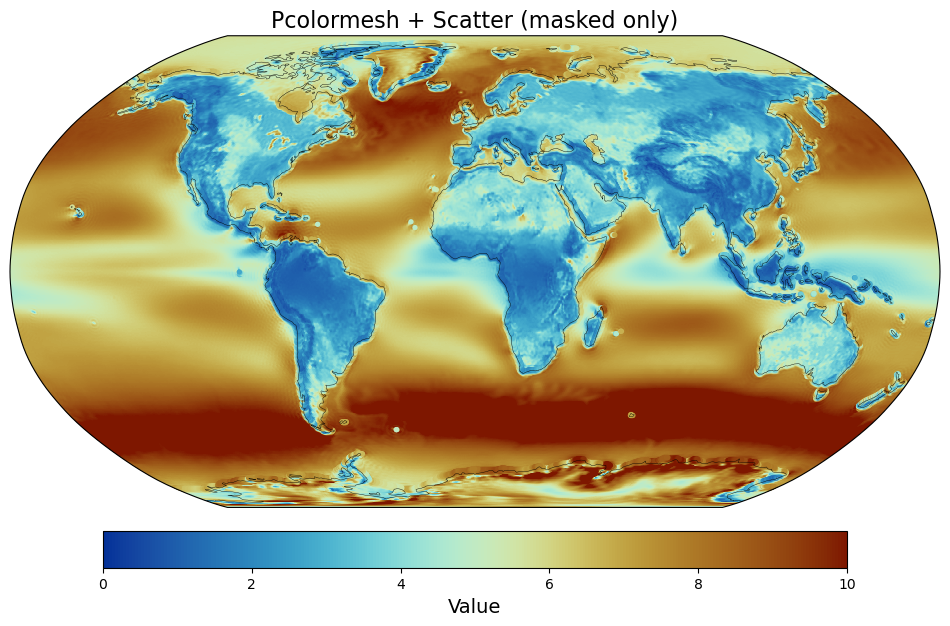

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmcrameri.cm as cm

# Meshgrid (lon2, lat2)
lon2, lat2 = np.meshgrid(lon, lat)

# Mask for scatter (non-NaN only)
mask_valid = ~np.isnan(hist_masked_np)

# Create figure + axis
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson())

# ==== 1) Pcolormesh (background) ====
pcm = ax.pcolormesh(
    lon2, lat2, hist,
    transform=ccrs.PlateCarree(),
    shading='auto',
    vmin=0, vmax=10,
    cmap=cm.roma_r     # 원하는 cmap
)

# ==== 2) Scatter overlay (masked values only) ====
sc = ax.scatter(
    lon2,
    lat2,
    c=hist_masked_np,
    s=15,
    transform=ccrs.PlateCarree(),
    cmap=cm.roma_r,
    vmin=0, vmax=10,
    edgecolors='none'
)

# ==== 3) Coastlines & title ====
ax.coastlines(linewidth=0.3)
ax.set_title("Pcolormesh + Scatter (masked only)", fontsize=16)

# ==== 4) Colorbar ====
cbar = plt.colorbar(pcm, ax=ax, orientation='horizontal', pad=0.03, shrink=0.8)
cbar.set_label("Value", fontsize=14)

plt.show()


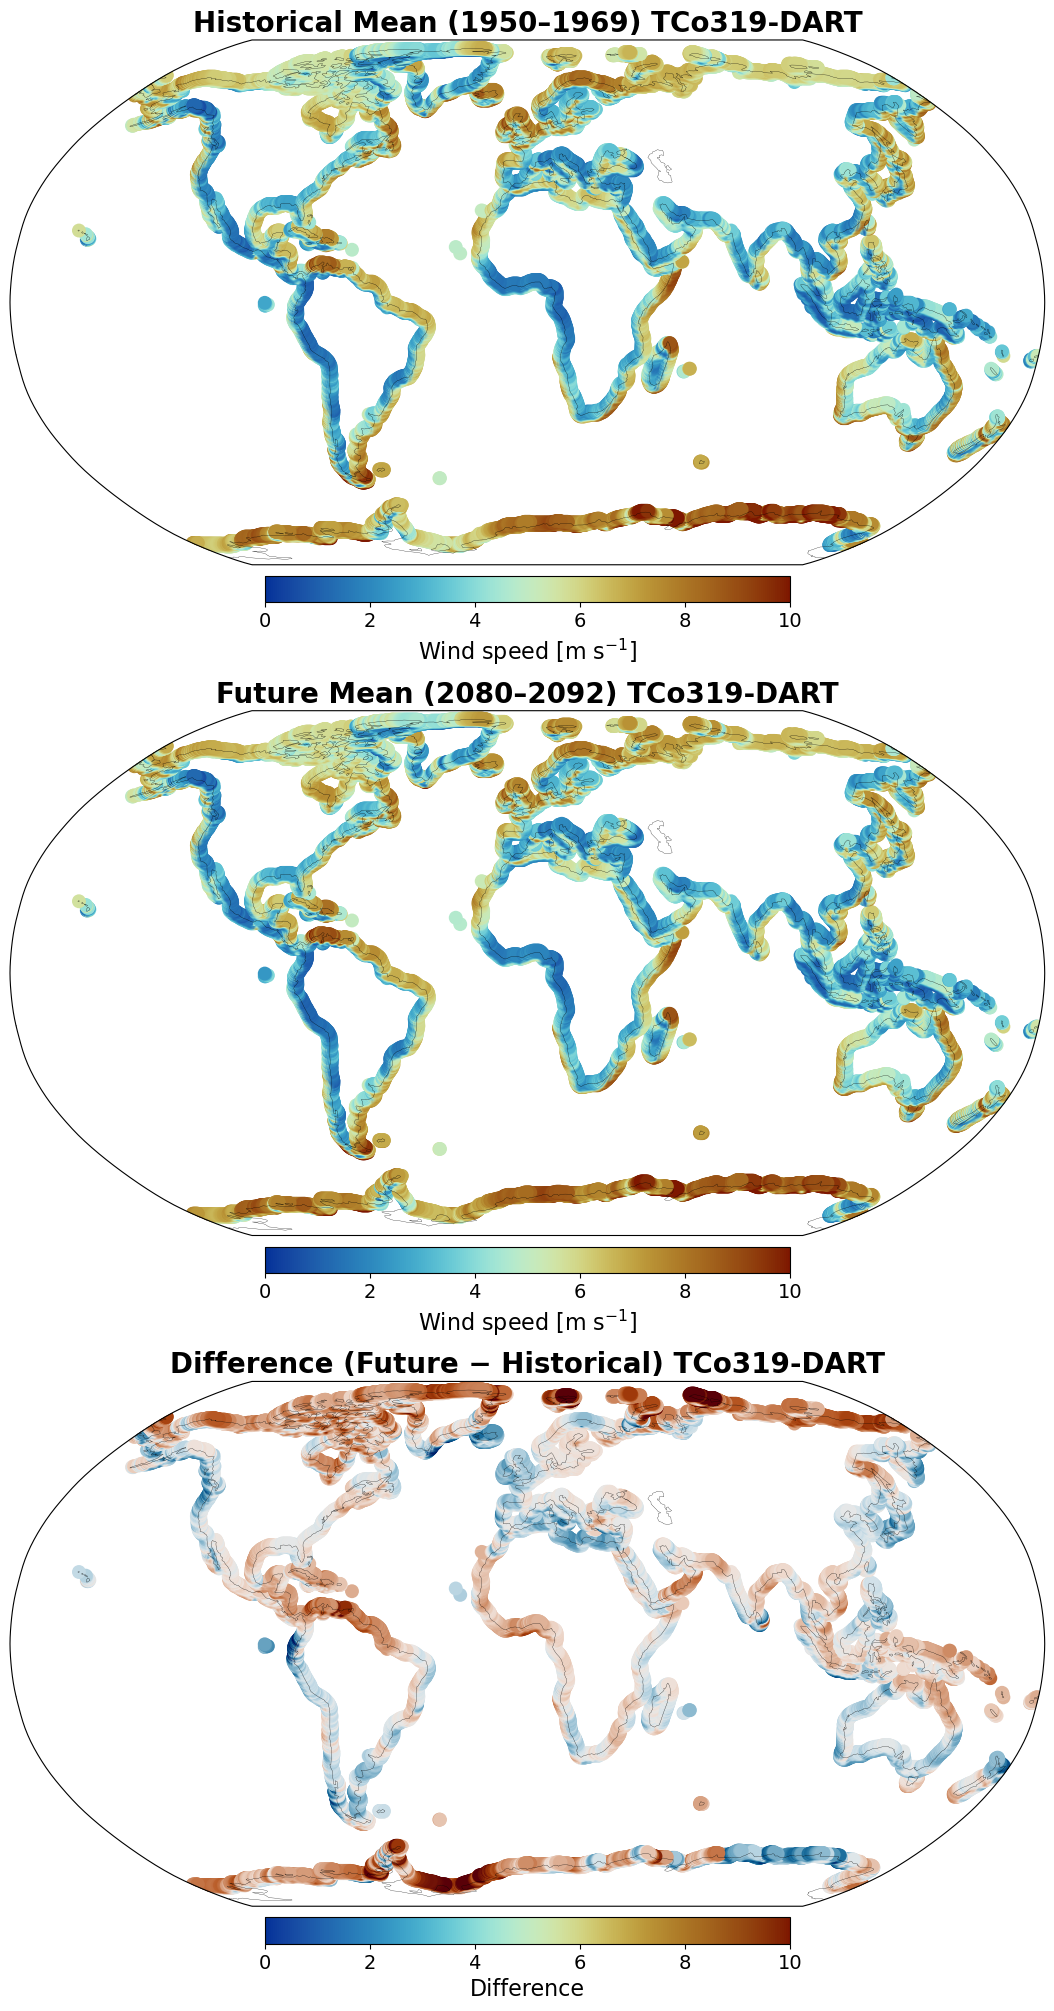

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmcrameri.cm as cm

lon2, lat2 = np.meshgrid(hist_masked.lon, hist_masked.lat)

datasets = [hist, fut, diff]           # background
masked_datasets = [hist_masked_np, fut_masked_np, diff_masked_np]  # masked wind speed
c_ranges = [(0, 10), (0, 10), (-1, 1)]

titles = [
    f'Historical Mean ({p_start_year}–{p_end_year}) {expid}',
    f'Future Mean ({f_start_year}–{f_end_year}) {expid}',
    f'Difference (Future − Historical) {expid}'
]

fig, axes = plt.subplots(
    3, 1,
    figsize=(12, 20),
    subplot_kw={'projection': ccrs.Robinson()},
    constrained_layout=True
)

for ax, data, masked_data, title, (vmin, vmax) in zip(
    axes, datasets, masked_datasets, titles, c_ranges
):

    # 1) background: pcolormesh 
    # pcm = ax.pcolormesh(
    #     hist_masked.lon,
    #     hist_masked.lat,
    #     data,
    #     transform=ccrs.PlateCarree(),
    #     shading='auto',
    #     vmin=vmin, vmax=vmax,
    #     cmap=cm.roma_r if "Difference" not in title else cm.vik
    # )

    sc = ax.scatter(
        lon2,
        lat2,
        c=masked_data,     
        s=100,
        transform=ccrs.PlateCarree(),
        vmin=vmin, vmax=vmax,
        cmap=cm.roma_r if "Difference" not in title else cm.vik,
        edgecolors="none"
    )
       
    # 지도 장식
    ax.set_global()
    ax.coastlines(linewidth=0.2)
    ax.set_title(title, fontsize=20, fontweight='bold')

    # 컬러바
    cbar = fig.colorbar(pcm, ax=ax, orientation='horizontal',
                        pad=0.02, shrink=0.75, fraction=0.05)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label(
        f"{long_name} [m s$^{{-1}}$]" if "Difference" not in title else "Difference",
        size='16'
    )

plt.show()
